# DESeq2 Analysis of 2015 Data

In this notebook, we will reproduce the dendrograms from the 2015 data shown in the welcome slides

## Load packages

Load requisite R packages. 

In [1]:
library(DESeq2)
library(tools)
library(dendextend)
library(dplyr)
library(RColorBrewer)
options(width=100)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The following objects are maske

## Prepare for Data Import

First set the directory under which the HTSeq count files are stored

In [2]:
datadir<-"~/work/HTS_SummerCourse_2017/Materials/Statistics/08032017/Data/2015"

Next, put the filenames into a data frame

In [3]:
phdata<-data.frame(fname=list.files(path=datadir,pattern="*.csv"),stringsAsFactors=FALSE)

It is always a good idea to check the dimension of the file you have read in

In [4]:
dim(phdata)

[1] 30  1

Extract the label from the filename. 

In [5]:
phdata <- phdata %>% transmute(sample=substr(fname,1,4),fname)

Add some design info to the data frame. We will add the treatment factor (the first character of the sample string: 7 or 8), the replicate id (the second character in the 

Note that tools::md5sum will add the MD5 signature for each of the HTSeq count files. You should keep track of these for the purpose of conducting reproducible analysis

In [6]:
phdata <- phdata %>% 
                mutate(trt=as.factor(substr(sample,1,1)),
                       repl=substr(sample,2,2),
                       team=substr(sample,4,4),
                       md5=tools::md5sum(file.path(datadir,fname)))
head(phdata)

sample    fname trt repl team  md5
1   7A_E 7A_E.csv   7    A    E <NA>
2   7A_G 7A_G.csv   7    A    G <NA>
3   7A_K 7A_K.csv   7    A    K <NA>
4   7A_N 7A_N.csv   7    A    N <NA>
5   7A_P 7A_P.csv   7    A    P <NA>
6   7B_E 7B_E.csv   7    B    E <NA>

Now, we import the counts. Note that the first argument is the sample table while the second is the directory storing the count files. The last argument specifies the design. More on this later.

In [7]:
dds<-DESeqDataSetFromHTSeqCount(sampleTable=phdata,directory=datadir,design=~ trt)

## Estimate library specific size factors and gene specific dispersion paramaters

Estimate Size factors

In [8]:
dds<-estimateSizeFactors(dds)

Estimate dispersion parameters

In [9]:
dds<-estimateDispersions(dds)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Inspect object

In [10]:
dds

class: DESeqDataSet 
dim: 4444 30 
metadata(1): version
assays(2): counts mu
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(9): baseMean baseVar ... dispOutlier dispMAP
colnames(30): 7A_E 7A_G ... 8C_N 8C_P
colData names(5): trt repl team md5 sizeFactor

### Create dendrograms

For this tutorial, we will use t he expression data based on rlog transformation.

In [11]:
rlogexp<-assay(rlog(dds))

Next, we create the dendrogram object using hierarchical clustering using complete linkage (method="complete"). 

Note that you have you transpose the expression matrix as R assumes that the samples are along the rows and that the genes are across the columns. This is accomplished using the t() function. Next, you create the distance matrix for this expression matrix using the dist() function. Afterwards, you conduct hierachical clustering on the basis of complete linkage using this distance matrix usin the dist() function. Finally, the results from the clustering is converted into a dendrogram class using the as.dendrogram() function

In [13]:
dend <- rlogexp %>%
                t %>% 
                dist %>% 
                hclust(method="complete") %>% 
                as.dendrogram

Let's look as a plot

In [14]:
dend %>% plot

Next, we will add some eye candy to this dendrogram. We will add the treatment label as symbols and the group/team labels as colors. Note that one can extract the labels from the dendrogram using the labels() function

In [15]:
labels(dend)

[1] "8A_N" "8A_K" "8B_K" "8C_K" "8C_E" "8A_E" "8B_E" "8B_N" "8C_N" "8B_P" "8A_P" "8C_P" "8A_G"
[14] "7B_G" "8B_G" "7A_G" "7C_G" "8C_G" "7B_N" "7A_N" "7C_N" "7A_K" "7B_K" "7C_K" "7B_E" "7A_P"
[27] "7B_P" "7C_P" "7A_E" "7C_E"

Now use this information to create a treatment label vector

In [16]:
trtlab<-c(2,19)[factor(substr(labels(dend),1,1))]
trtlab

[1] 19 19 19 19 19 19 19 19 19 19 19 19 19  2 19  2  2 19  2  2  2  2  2  2  2  2  2  2  2  2

and then a group label vector

In [17]:
grplab<-brewer.pal(5,"Set1")[factor(substr(labels(dend),4,4))]
grplab

[1] "#984EA3" "#4DAF4A" "#4DAF4A" "#4DAF4A" "#E41A1C" "#E41A1C" "#E41A1C" "#984EA3" "#984EA3"
[10] "#FF7F00" "#FF7F00" "#FF7F00" "#377EB8" "#377EB8" "#377EB8" "#377EB8" "#377EB8" "#377EB8"
[19] "#984EA3" "#984EA3" "#984EA3" "#4DAF4A" "#4DAF4A" "#4DAF4A" "#E41A1C" "#FF7F00" "#FF7F00"
[28] "#FF7F00" "#E41A1C" "#E41A1C"

First add the treatment label. The symbol use for each leaf is controlled by "leaves_pch" (you can use label_cex and leaves_cex to control the relative size of the labels or leaves)

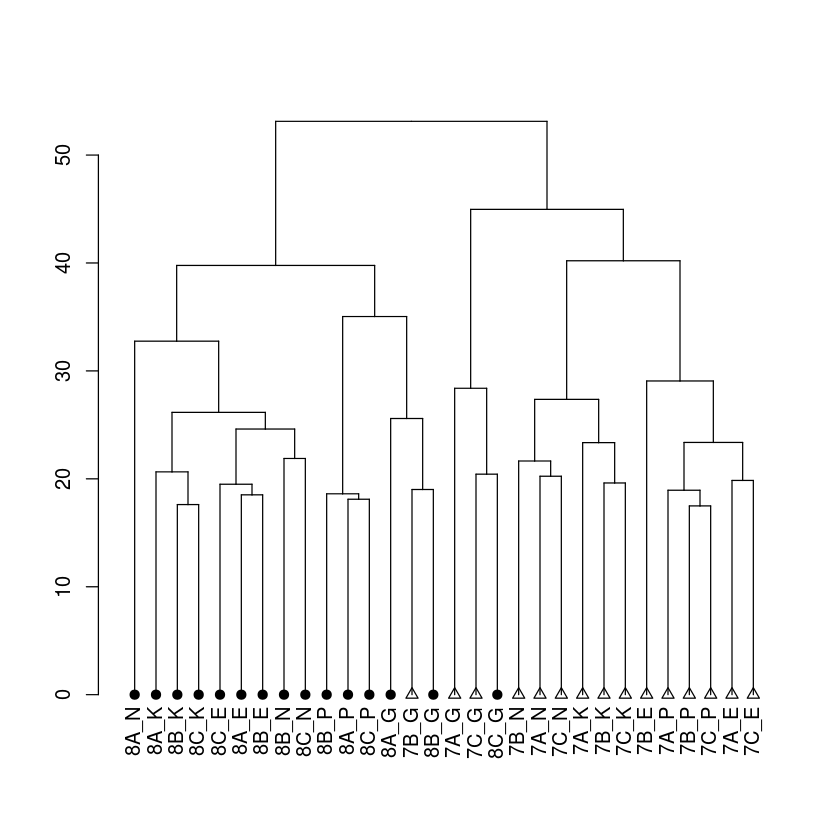

In [18]:
dend %>% 
    set("labels_cex",1) %>% 
    set("leaves_pch",trtlab) %>% 
    set("leaves_cex",1) %>% 
    plot

Now, lets add the group label to the above. The color of each label is controlled by "labels_col"

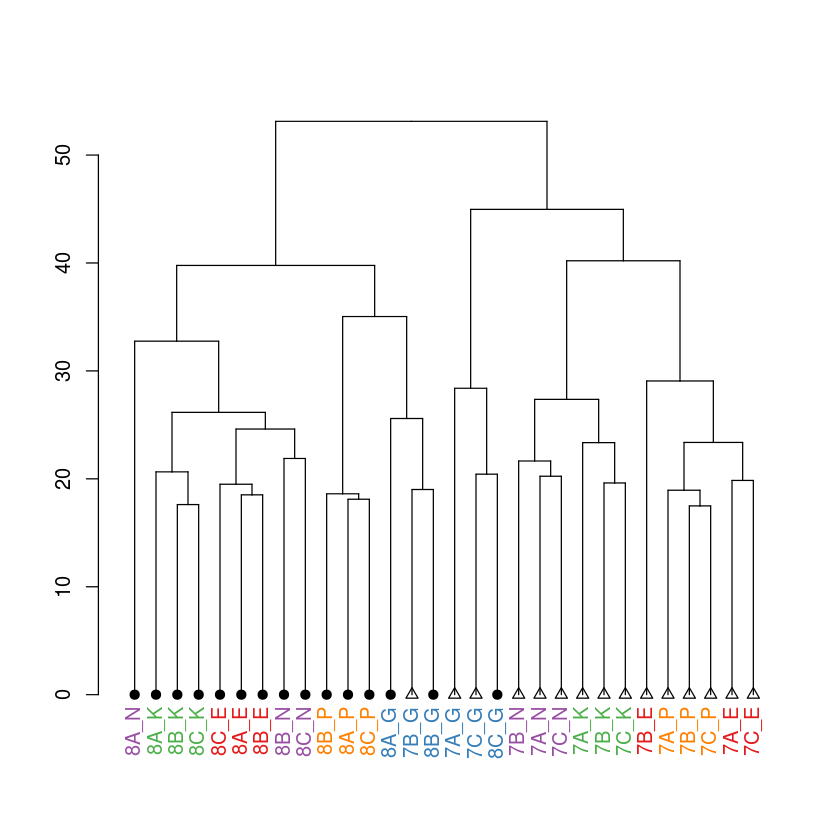

In [19]:
dend %>% 
    set("labels_cex",1) %>% 
    set("labels_col",grplab) %>% 
    set("leaves_pch",trtlab) %>% 
    set("leaves_cex",1) %>% 
    plot

You can also add a title to the plot

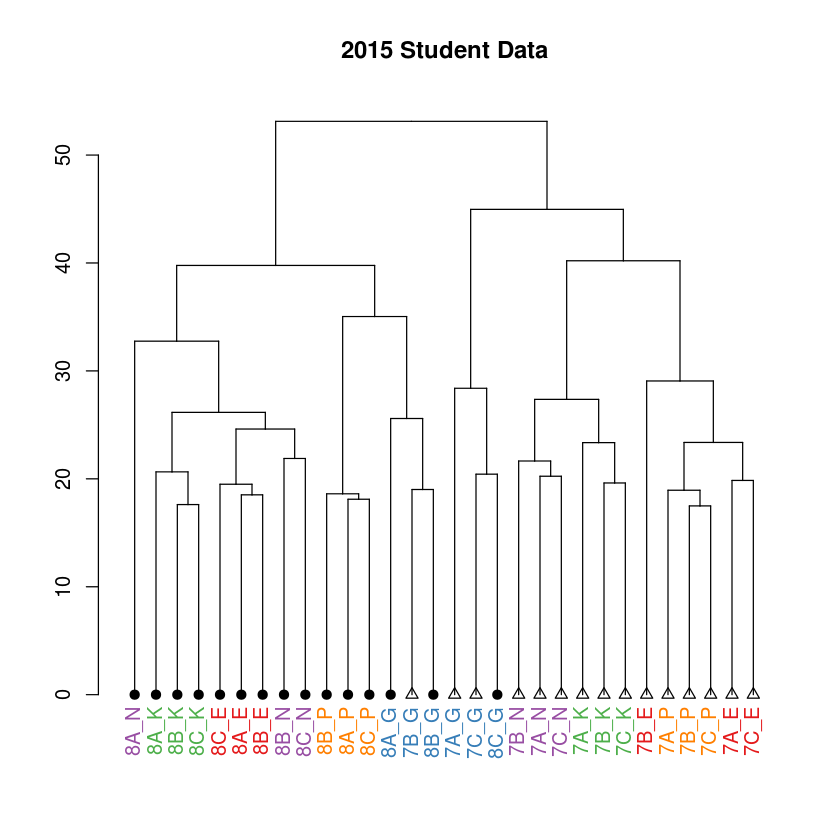

In [20]:
dend %>% 
    set("labels_cex",1) %>% 
    set("labels_col",grplab) %>% 
    set("leaves_pch",trtlab) %>% 
    set("leaves_cex",1) %>% 
    plot(main="2015 Student Data")

### Repeat the analysis using expression data based on limma::voom with HC with single linkage:

Get expression matrix using voom

In [21]:
voomexp<-limma::voom(assay(dds))$E

Create dendrogram object based on single linkage

In [22]:
dend <- voomexp %>% 
        t %>% 
        dist %>% 
        hclust(method="single") %>% 
        as.dendrogram

Create plot

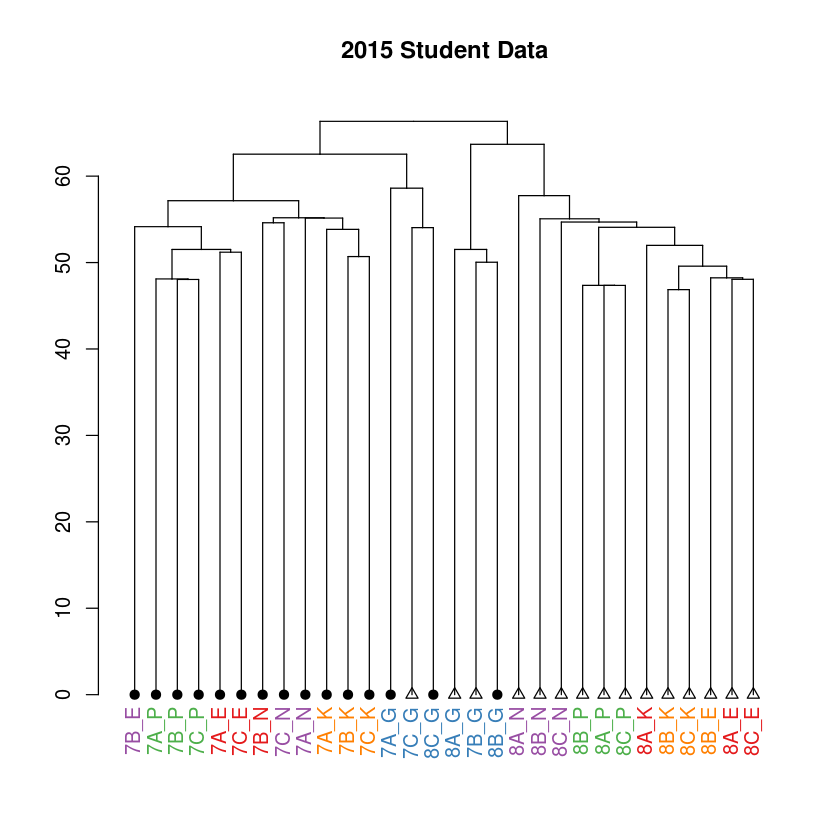

In [23]:
dend %>% 
    set("labels_cex",1) %>% 
    set("labels_col",grplab) %>% 
    set("leaves_pch",trtlab) %>% 
    set("leaves_cex",1) %>% 
    plot(main="2015 Student Data")

### Get Session Information

In [24]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_US.UTF-8       
 [4] LC_COLLATE=en_US.UTF-8     LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                  LC_ADDRESS=C              
[10] LC_TELEPHONE=C             LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] tools     parallel  stats4    stats     graphics  grDevices utils     datasets  methods  
[10] base     

other attached packages:
 [1] RColorBrewer_1.1-2         dplyr_0.5.0                dendextend_1.5.2          
 [4] DESeq2_1.14.1              SummarizedExperiment_1.4.0 Biobase_2.34.0            
 [7] GenomicRanges_1.26.4       GenomeInfoDb_1.10.3        IRanges_2.8.2             
[10] S4Vectors_0.12.2           BiocGenerics_0.20.0       

loaded via a namespace (and not attached):
 [1] viridis_0